<a href="https://colab.research.google.com/github/sunheehee/kaggle-study/blob/main/%5Bkaggle%5D_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필사한 코드 원본: https://www.kaggle.com/code/miguelfzzz/house-price-prediction-lasso-ridge-and-more#Missing-values

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DArt-B 5기/kaggle study/house price /train.csv')
test = pd.read_csv('/content/drive/MyDrive/DArt-B 5기/kaggle study/house price /test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA

<ipython-input-54-ac3a562b63d6>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SalePrice', y=corr.index, data=corr, palette=colors)
<ipython-input-54-ac3a562b63d6>:17: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x='SalePrice', y=corr.index, data=corr, palette=colors)


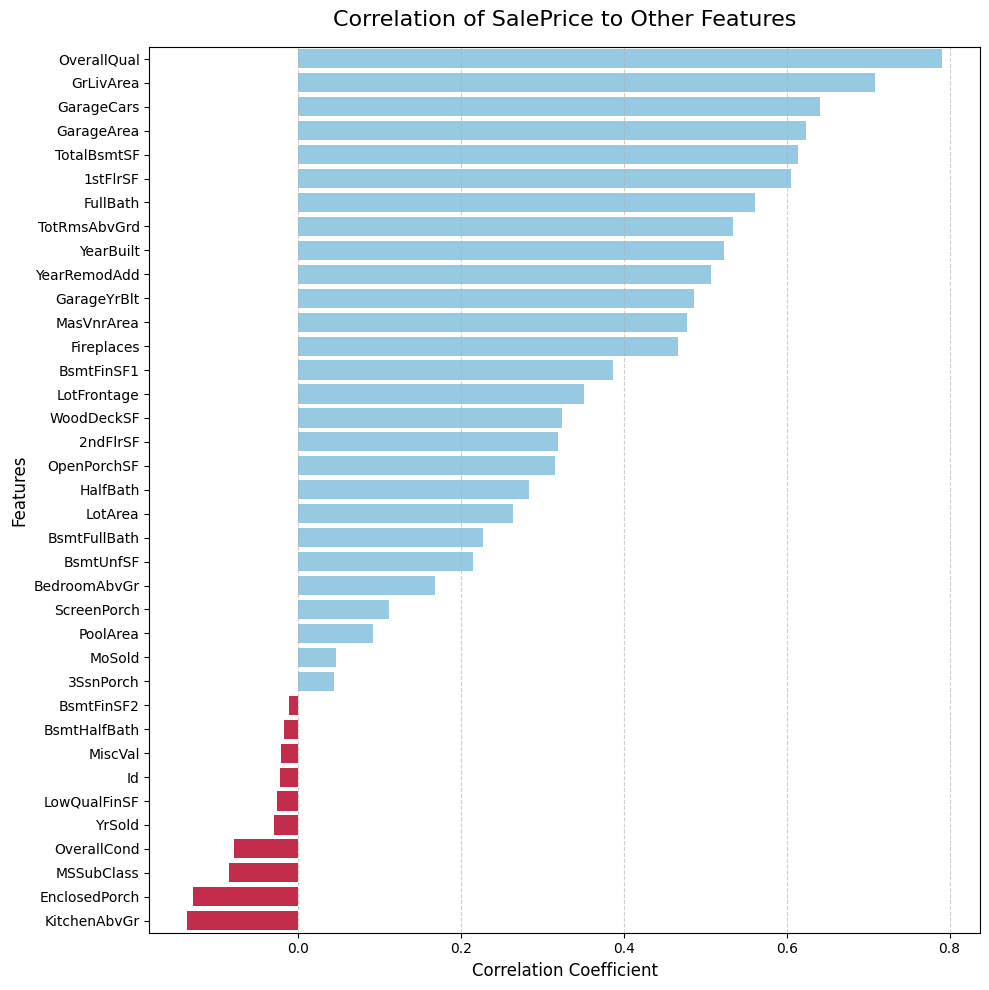

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#변수와 SalePrice간의 상관관계 시각화 후 영향확인(양의 영향/음의 영)
# corr = train[train.columns].corr()['SalePrice'][:].sort_values(ascending=True).to_frame() #기존 코드지만 수치형이 아닌 변수도 있어서 에러 발생
num_train = train.select_dtypes(include='number')
corr = train[num_train.columns].corr()['SalePrice'][:].sort_values(ascending=False).to_frame()
corr = corr.drop(corr[corr.SalePrice > 0.99].index)

# 색상 설정: 음수면 빨강, 양수면 하늘색
colors = np.where(corr['SalePrice'] < 0, 'crimson', '#89CFF0')

#기존코드 오류나서 지피티에서 바꿈
# 시각화
plt.figure(figsize=(10, 10))
sns.barplot(x='SalePrice', y=corr.index, data=corr, palette=colors)

# 제목, 레이블
plt.title("Correlation of SalePrice to Other Features", fontsize=16, pad=15)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)

# 격자선, 스타일
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**코드 이해하기**

✅train[train.columns]는 사실 train 데이터셋과 동일하지만, 이후의 재사용 가능성과 유지보수를 고려했을 때 train[train.columns]의 형식으로 작성

✔️ train.corr() → 전체 수치형 변수 간 상관계수 계산

✔️['SalePrice'][:] → SalePrice와 다른 변수들 간의 상관관계만 가져옴

✔️.to_frame() : series → DF형식으로 가져옴


**그래프 해석하기**

상관계수 0.6이상인 변수들에 한해서 높은 양의 상관관계를 가진 변수들이라고 칭함.

집값을 에측하는 데 있어 높은 양의 상관관계를 가진 변수들

- OverallQual: 전반적인 자재 및 마감 품질

- GrLivArea: 지상층 거주 면적 (평방피트 기준)

- GarageCars: 차 수용 기준으로 본 차고 크기

- GarageArea: 차고의 전체 면적 (평방피트 기준)

- TotalBsmtSF: 지하실 전체 면적 (평방피트 기준)

- 1stFlrSF: 1층의 면적 (평방피트 기준)



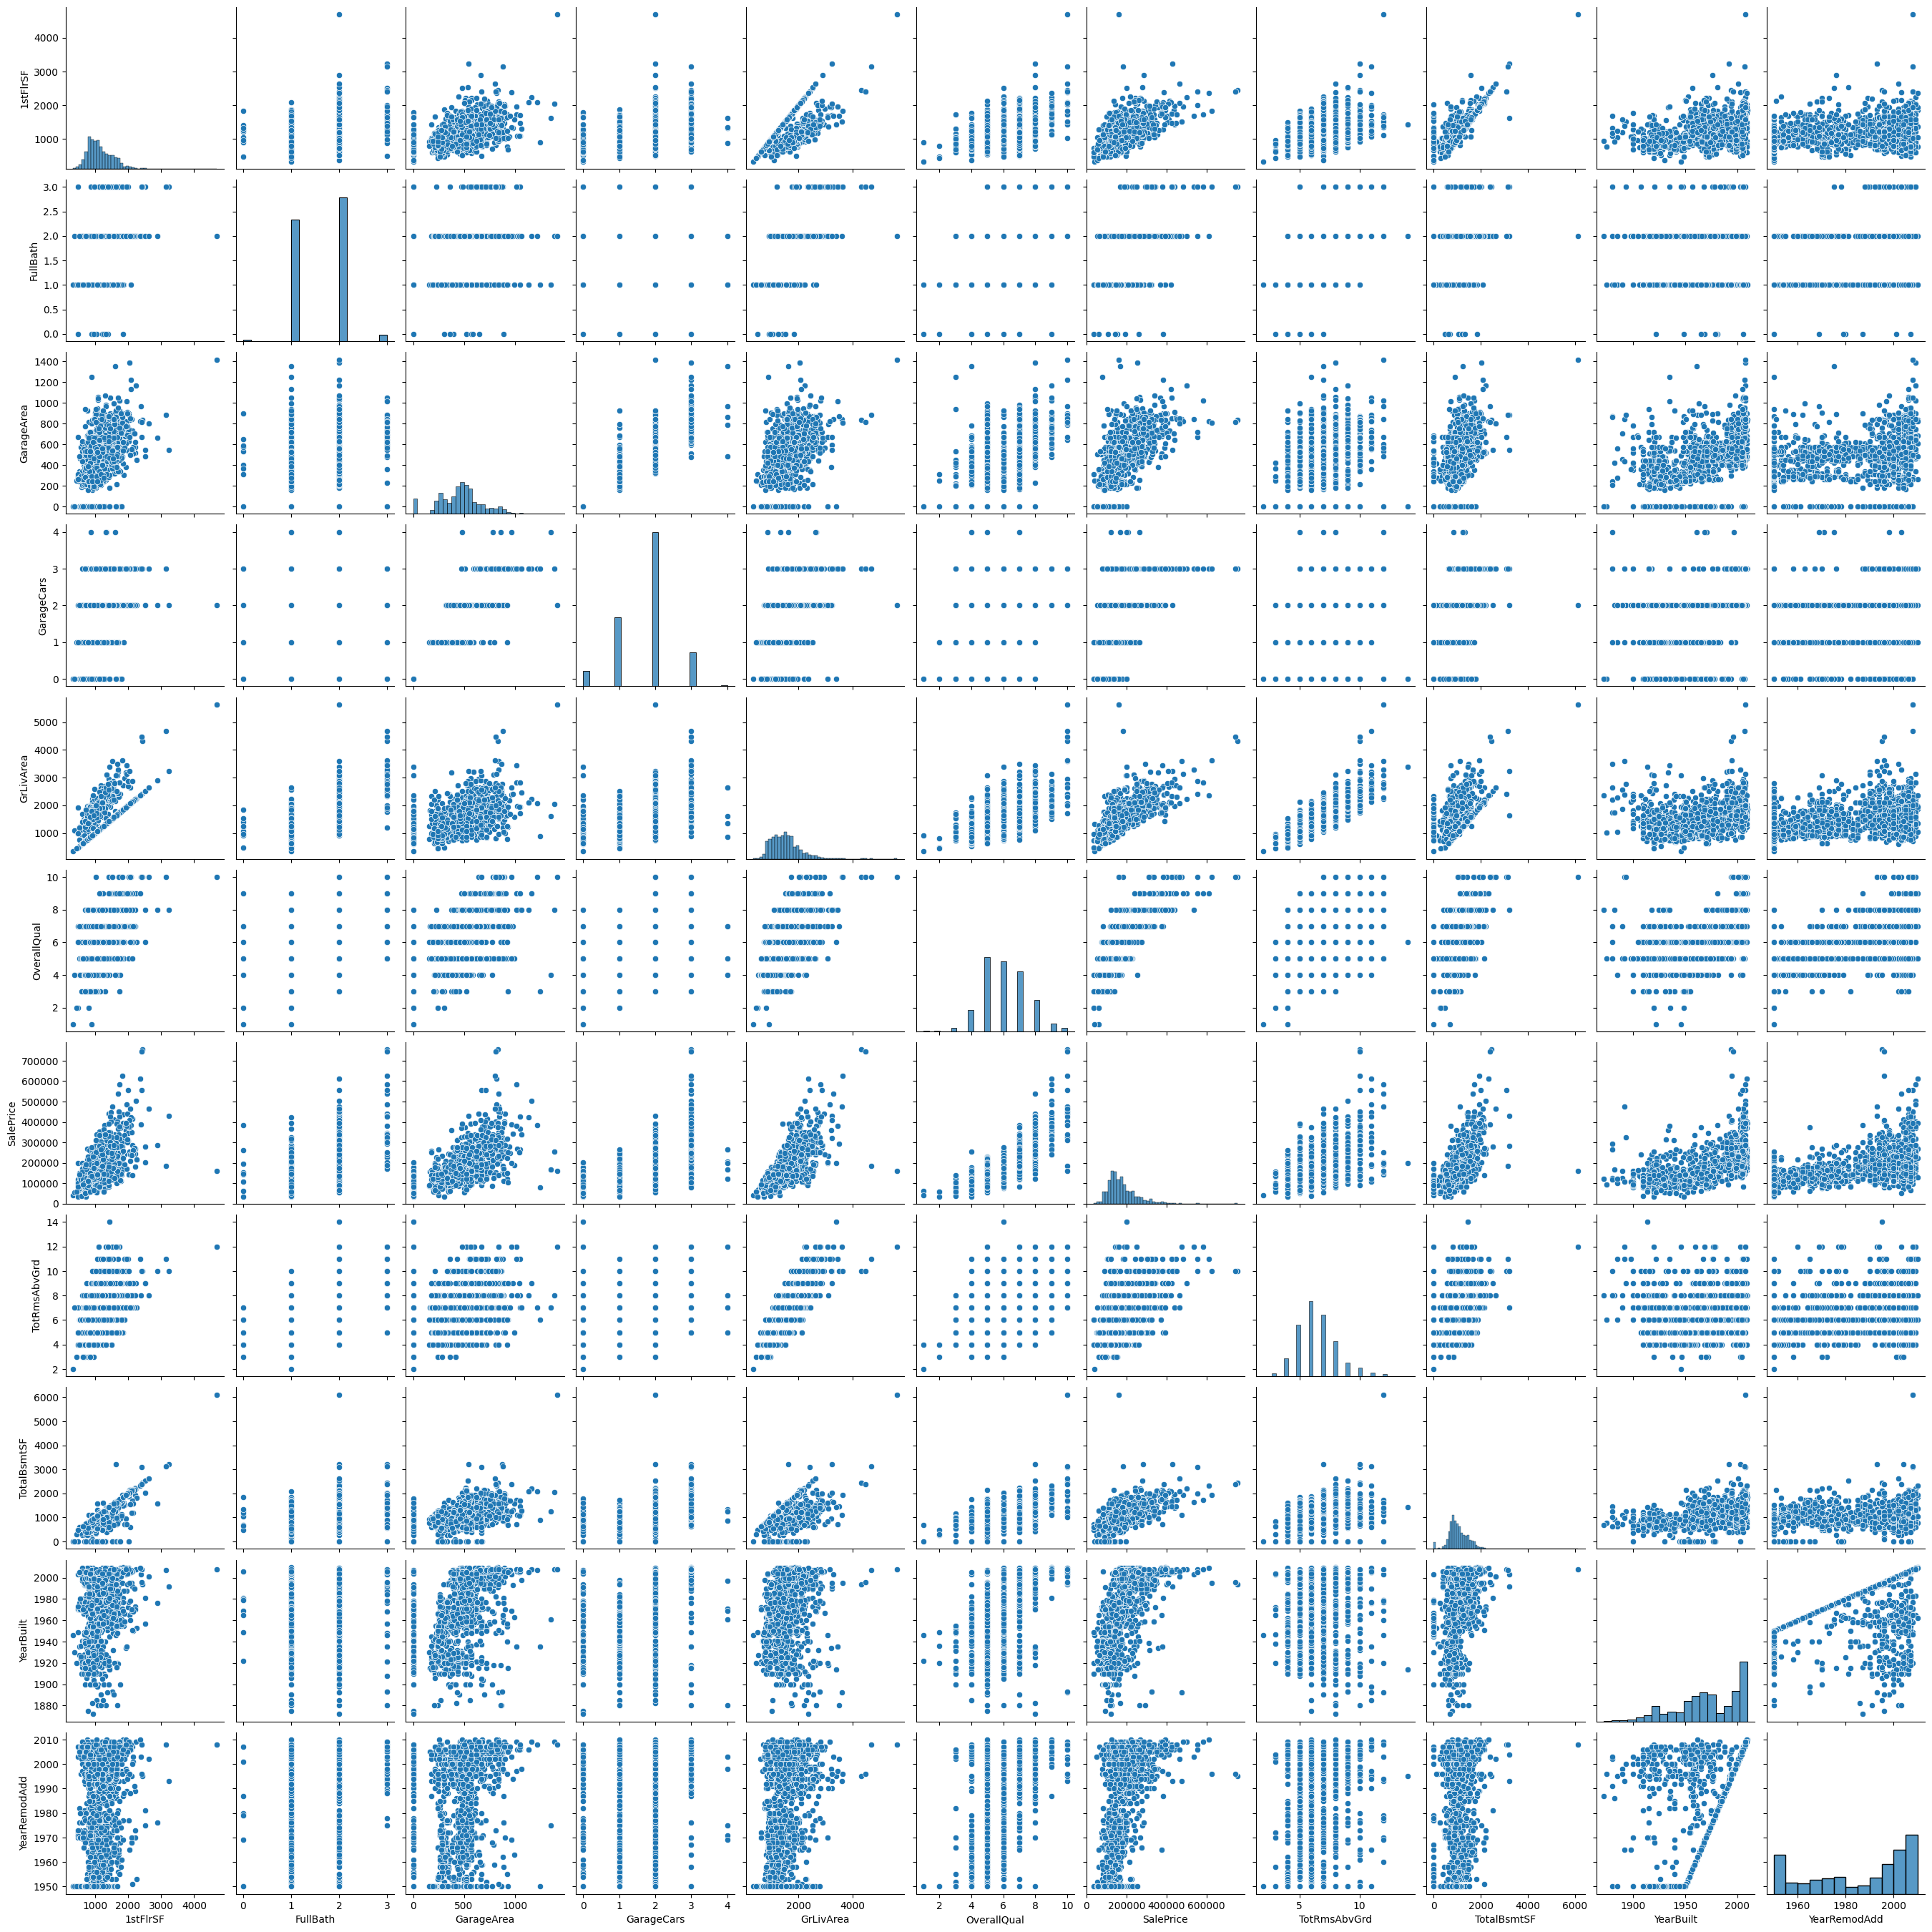

In [ ]:
#pariplot 그리기
top_corr=corr['SalePrice'].sort_values(ascending=False).head(10).index #SalePrice와 상관관계가 높은 10개의 변수 선택
top_corr=top_corr.union(['SalePrice']) # 그래프에서 SalePrice도 같이 보여주기 위해서 강제로 추가 (union)

sns.pairplot(train[top_corr]);

# Data Processing and Cleaning

In [ ]:
print('Training Shape:', train.shape)
print('Test Shape:', test.shape)

Training Shape: (1460, 81)
Test Shape: (1459, 80)


In [ ]:
#  각 데이터셋의 iD는 별도 저장
train_id = train['Id']
test_id = test['Id']
del train['Id']
del test['Id']

## Outliers

In [ ]:
train1 = train.copy()
train1 = train1.drop(train1[(train1['GarageArea']>1200) & (train1['SalePrice']<300000)].index)  #GarageArea가 매우 넓은데 가격이 낮은 경우 -> 이상치라고 판단
train1 = train1.drop(train1[(train1['GrLivArea']>4000) & (train1['SalePrice']<300000)].index)  #GrLivArea가 매우 넓은데 가격이 낮은 경우 -> 이상치라고 판단
train1 = train1.drop(train1[(train1['TotalBsmtSF']>5000)].index)    # 지하실 면적이 과하게 큰 경우 -> 가격 조건 상관없이 이상치라고 판단

In [ ]:
# Q1 = train['GarageArea'].quantile(0.25)
# Q3 = train['GarageArea'].quantile(0.75)
# IQR = Q3 - Q1
# upper_bound = Q3 + 1.5 * IQR
# under_bound = Q1 - 1.5 * IQR

# print(upper_bound, under_bound)

# ## IQR떄려본 결과, 위의 이상치라고 판단하는 기준의 값과 일치하지 않음.
# ## 대체 어떤 기준으로 이상치라고 판단하는 기준을 설정한걸까??

938.25 -27.75


In [ ]:
print('Outliers removed =', train.shape[0] - train1.shape[0])

Outliers removed = 5


# X와 y분리

In [ ]:
X=train1.drop('SalePrice', axis=1)
y=train1['SalePrice'].to_frame()

# 변수를 추가해서 나중에 다시 train과 test를 분리할 때 용이하도록 함.
# ex: df[df['train'] ==1 ] -> train
X['train'] = 1
test['train'] = 0

# 데이터 정제를 쉽게 할 수 있도록 두개의 데이터 셋 합치기
df=pd.concat([test,X])

✔️ concat의 기본값은 axis=0 이기 때문에, 행 방향으로 위 위아래를 이어붙임

In [ ]:
print('Count of Features per Data Type:')
df.dtypes.value_counts()

Count of Features per Data Type:


,count
object,43
int64,26
float64,11


In [ ]:
# Do we have duplicates?
print('Number of Duplicates:', len(df[df.duplicated()]))


# Do we have missing values?
print('Number of Missing Values:', df.isnull().sum().sum())

Number of Duplicates: 0
Number of Missing Values: 15686


# Feature Engineering

In [ ]:
print('Missing Values per Column:')
df.isnull().sum().sort_values(ascending=False).head(25)
#MasVnrTyp(석조 베니어 타입??)이 원본과 다르게 나오고 있음 (원본:24 -> 1765)

Missing Values per Column:


,0
PoolQC,2905
MiscFeature,2810
Alley,2716
Fence,2343
MasVnrType,1765
FireplaceQu,1419
LotFrontage,485
GarageYrBlt,159
GarageQual,159
GarageCond,159


### 결측치 처리 1

✔️ PoolQC (수영장 품질)
    
 NaN은 수영장이 없는 집을 의미함
    
 → "None" 또는 "NoPool" 등으로 대체 가능

---

✔️MiscFeature (기타 부가 기능)

NaN은 기타 항목이 없는 경우를 의미함

→ "None"으로 처리

---

✔️ Alley (골목길 접근 형태)

NaN은 골목길 접근이 없는 경우

→ "None" 또는 "NoAlleyAccess"

---

✔️Fence (울타리 종류)

NaN은 울타리가 없는 경우

→ "None"으로 대체

---

✔️FireplaceQu (벽난로 품질)

NaN은 벽난로가 없는 집을 의미함

→ "None" 처리

---

✔️LotFrontage(거리와 주택 사이의 거리)
- 단위;피트(ft)
- 결측값 처리 방법: 해당 이웃과의 중앙값으로 대체
    ← 지역별 토지 구조를 반영하는 합리적 방식


In [ ]:
df['PoolQC'] = df['PoolQC'].fillna('None')
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['Alley'] = df['Alley'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda i:i.fillna(i.median())) #lambda함수 사용법에 익숙해질것!

### 결측치 처리2


---

✔️ Garage 관련 변수들(Garage로 시작)

NaN은 해당 집에 차고가 없음을 의미

Garage로 시작하는 변수들만 추출해서 살펴보기

In [ ]:
# Garage관련 변수들 탐색
garage_cols = [col for col in df if col.startswith('Garage')]
df[garage_cols]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,1961.0,Unf,1.0,730.0,TA,TA
1,Attchd,1958.0,Unf,1.0,312.0,TA,TA
2,Attchd,1997.0,Fin,2.0,482.0,TA,TA
3,Attchd,1998.0,Fin,2.0,470.0,TA,TA
4,Attchd,1992.0,RFn,2.0,506.0,TA,TA
...,...,...,...,...,...,...,...
1455,Attchd,1999.0,RFn,2.0,460.0,TA,TA
1456,Attchd,1978.0,Unf,2.0,500.0,TA,TA
1457,Attchd,1941.0,RFn,1.0,252.0,TA,TA
1458,Attchd,1950.0,Unf,1.0,240.0,TA,TA


In [ ]:

df[garage_cols].isnull().sum()

,0
GarageType,157
GarageYrBlt,159
GarageFinish,159
GarageCars,1
GarageArea,1
GarageQual,159
GarageCond,159


✅ garage와 관련된 범수들은 범주형과 수치형이 섞여있는 것을 확인함.

✔️garage관련 변수들:

1. 범주형 변수

    Nan값은 '없음'을 의미하는 'None'문자열로 대체

2. 수치형 변수

    NaN 값은 0으로 대체

    **개인적의문: 위의 데이터를 살펴보면, GarageYrBlt의 결측치는 0으로 바꿀게 아니라 드랍해야하는거 아님??


In [ ]:
# 개인적 의문용 확인 코드
# garage_cols 중에서 수치형 변수만 추출
num_cols = df[garage_cols].select_dtypes(include='number').columns

# 그 중에서 하나라도 NaN인 행 추출
df.loc[df[num_cols].isnull().any(axis=1), garage_cols]


,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
53,NaN,NaN,NaN,0.0,0.0,NaN,NaN
71,NaN,NaN,NaN,0.0,0.0,NaN,NaN
79,NaN,NaN,NaN,0.0,0.0,NaN,NaN
92,NaN,NaN,NaN,0.0,0.0,NaN,NaN
96,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
1349,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1407,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1449,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1450,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [ ]:
for i in df[garage_cols].select_dtypes(exclude='object').columns: df[i] = df[i].fillna(0)
for i in df[garage_cols].select_dtypes(include='object').columns: df[i] = df[i].fillna('None')

In [ ]:
df[garage_cols].isnull().sum()

,0
GarageType,0
GarageYrBlt,0
GarageFinish,0
GarageCars,0
GarageArea,0
GarageQual,0
GarageCond,0


### 결측치 처리 3
✔️Bsmt로 시작하는 특징들

NaN은 지하실이 없는 집을 의미
→ "None" 또는 0으로 대체 (타입에 따라)

---

✔️ Mas로 시작하는 특징들 (Masonry Veneer)

NaN은 외벽 마감이 벽돌(석재)이 아닌 집을 의미
→ "None" 또는 0으로 대체

---

✔️ MSZoning (용도 구분)
MSZoning은 매매된 부동산의 일반 용도 구분(Zone)을 나타냄

결측값은 해당 지역(Neighborhood)에서 가장 많이 등장하는 구역 유형(최빈값)으로 채움

---

In [ ]:
#Bsmt결측치 채우기
bsmt_cols = [col for col in df if col.startswith('Bsmt')]

for i in df[bsmt_cols].select_dtypes(exclude='object').columns: df[i] = df[i].fillna(0)
for i in df[bsmt_cols].select_dtypes(include='object').columns: df[i] = df[i].fillna('None')

#Mas 결측치 채우기
mas_cols = [col for col in df if col.startswith('Mas')]

for i in df[mas_cols].select_dtypes(exclude='object').columns: df[i] = df[i].fillna(0)
for i in df[mas_cols].select_dtypes(include='object').columns: df[i] = df[i].fillna('None')


#MSZoning 결측치 채우기
df['MSZoning'] = df.groupby('Neighborhood')['MSZoning'].transform(lambda i: i.fillna(i.value_counts().index[0]))



In [ ]:
print('Missing Values left:')
df.isnull().sum().sort_values(ascending=False).head(10)

Missing Values left:


,0
Utilities,2
Functional,2
SaleType,1
TotalBsmtSF,1
Exterior2nd,1
Electrical,1
Exterior1st,1
KitchenQual,1
LandContour,0
MSSubClass,0


In [ ]:
# 나머지 결측치들은 그냥 최빈값으로 전환
df=df.fillna(df.mode().iloc[0])

## 카테고리형으로 바꾸기

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2914 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2914 non-null   int64  
 1   MSZoning       2914 non-null   object 
 2   LotFrontage    2914 non-null   float64
 3   LotArea        2914 non-null   int64  
 4   Street         2914 non-null   object 
 5   Alley          2914 non-null   object 
 6   LotShape       2914 non-null   object 
 7   LandContour    2914 non-null   object 
 8   Utilities      2914 non-null   object 
 9   LotConfig      2914 non-null   object 
 10  LandSlope      2914 non-null   object 
 11  Neighborhood   2914 non-null   object 
 12  Condition1     2914 non-null   object 
 13  Condition2     2914 non-null   object 
 14  BldgType       2914 non-null   object 
 15  HouseStyle     2914 non-null   object 
 16  OverallQual    2914 non-null   int64  
 17  OverallCond    2914 non-null   int64  
 18  YearBuilt    

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2914.0,57.112217,42.474217,20.0,20.00,50.0,70.00,190.0
LotFrontage,2914.0,69.406829,21.191130,21.0,60.00,70.0,80.00,313.0
LotArea,2914.0,10128.200755,7798.584415,1300.0,7473.00,9450.0,11546.25,215245.0
OverallQual,2914.0,6.087509,1.405287,1.0,5.00,6.0,7.00,10.0
OverallCond,2914.0,5.566232,1.113182,1.0,5.00,5.0,6.00,9.0
YearBuilt,2914.0,1971.291352,30.286886,1872.0,1953.25,1973.0,2001.00,2010.0
YearRemodAdd,2914.0,1984.254633,20.887641,1950.0,1965.00,1993.0,2004.00,2010.0
MasVnrArea,2914.0,100.879204,178.071569,0.0,0.00,0.0,162.75,1600.0
BsmtFinSF1,2914.0,438.919012,444.059991,0.0,0.00,368.0,732.75,4010.0
BsmtFinSF2,2914.0,49.650309,169.311762,0.0,0.00,0.0,0.00,1526.0


In [ ]:
df['MSSubClass'] = df['MSSubClass'].astype(str)
df['MoSold'] = df['MoSold'].astype(str) #월 변수는 항상 카테고리 🌱
df['YrSold'] = df['YrSold'].astype(str) #5년치 데이터밖에 없음

## 관련 변수 만들기

In [ ]:
df['Total_House_SF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] #총 면적
df['Total_Home_Quality'] = (df['OverallQual'] + df['OverallCond']) / 2 #총 퀄리티 평균
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

| 욕실 종류         | 구성                              | 의미               | 가중치 |
|------------------|-----------------------------------|--------------------|--------|
| **FullBath**     | 샤워/욕조 + 세면대 + 변기         | **완전한 욕실**    | 1.0    |
| **HalfBath**     | 세면대 + 변기 (샤워/욕조 없음)     | **절반짜리 욕실**  | 0.5    |
| **BsmtFullBath** | 지하에 있는 FullBath              | 완전한 욕실        | 1.0    |
| **BsmtHalfBath** | 지하에 있는 HalfBath              | 절반 욕실          | 0.5    |


0.5를 곱하는 이유는 뭘까??

➡️욕실의 "기여도" 또는 "중요도"를 반영해서
실제 집의 가치나 면적 기여에 맞춰 계산하기 위해서

욕실의 가중 합계 = 사용가치를 표현하기 위함!

# 왜도 처리

특히, 비정규 분포를 따르는 수치형 변수들은 모델 성능에 악영향을 줄 수 있음.

In [ ]:
numeric_cols = df.select_dtypes(exclude='object').columns

skew_limit = 0.5
skew_vals = df[numeric_cols].skew()   # 각 수치형 변수들의 왜도 계산

#왜도값을 데이터프레임화 + 필터링
skew_cols = (skew_vals
             .sort_values(ascending=False) #왜도가 높은 순서대로 정렬
             .to_frame()    #series → DataFrame
             .rename(columns={0:'Skew'}) #컬럼명 Skew로 설정
             .query('abs(Skew) > {0}'.format(skew_limit)))  #임계값보다 큰 값만 추출

skew_cols

,Skew
MiscVal,21.949442
PoolArea,17.688586
LotArea,13.168399
LowQualFinSF,12.084424
3SsnPorch,11.371955
KitchenAbvGr,4.300206
BsmtFinSF2,4.144176
EnclosedPorch,4.002083
ScreenPorch,3.944742
BsmtHalfBath,3.929621


`.query(...)`: pandas.DataFrame에서 문자열을 이용해 SQL처럼 조건을 걸 수 있는 함수

- abs(Skew): Skew의 절댓값 계산
- '> {0} : 문자열 포매팅
- 바로 >skew_limit으로 쓸 수 없는 이유는 skew_limit을 컬럼명으로 오해해서 에러가 날 수 있기 때문

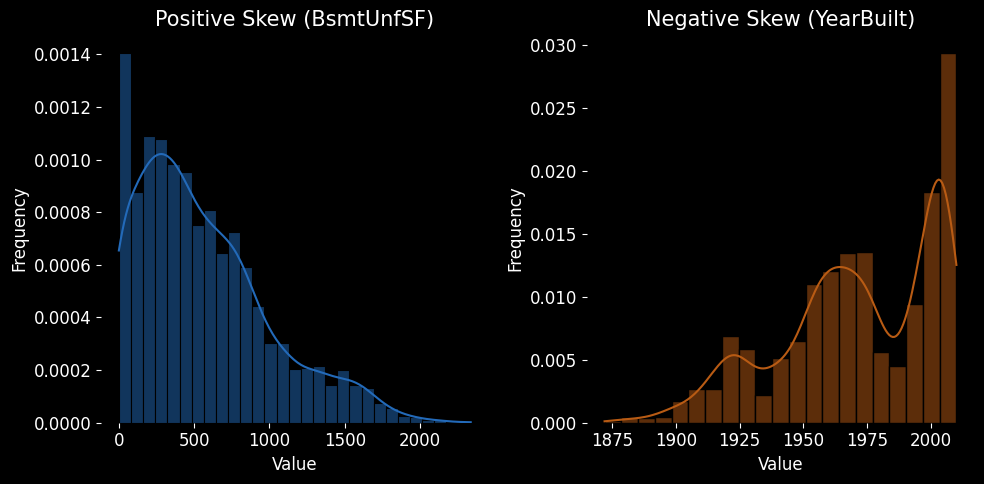

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 설정: 폰트 및 테마 스타일
mpl.rcParams['font.family'] = 'DejaVu Sans'  # 대체 가능 폰트
mpl.rcParams['font.size'] = 12

# 도화지 준비
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes

# 다크 배경 설정
fig.patch.set_facecolor('black')
ax1.set_facecolor('black')
ax2.set_facecolor('black')

# 히스토그램 그리기 (Seaborn)
sns.histplot(data=df, x='BsmtUnfSF', kde=True, stat='density', color='#236AB9', ax=ax1)
sns.histplot(data=df, x='YearBuilt', kde=True, stat='density', color='#B85B14', ax=ax2)

# 축/라벨 색상 및 설정 통일
for ax, title in zip([ax1, ax2], ['Positive Skew (BsmtUnfSF)', 'Negative Skew (YearBuilt)']):
    ax.set_xlabel('Value', color='white')
    ax.set_ylabel('Frequency', color='white')
    ax.set_title(title, fontsize=15, color='white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    # 축 테두리 제거
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
#박스콕스 변환
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

for col in skew_cols.index:
    df[col] = boxcox1p(df[col], boxcox_normmax(df[col] + 1))

/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:1317: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, prob = _stats_py.pearsonr(xvals, yvals)


BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

#### Box-Cox변환이란?

정규화 방법
- 양수만 입력 가능 >> 보통 적용 전에 1을 더하거나, 로그등의 방법을 씀

- 종 모양의 정규분포 모양으로 변환됨

- 다양한 곡선 형태를 적용할 수 있는데, 람다 값으로 곡선의 모양을 결정함.

➡️`scipy.stats.boxcox_normmax()`함수: 이 데이터에 가장 적합한 람다값을 통계적으로 자동 계산
    
    - λ=0.5: 제곱근 → 오른쪽 꼬리 줄이기 좋음

    - λ=0: 로그 → 분포를 압축해서 더 정규분포처럼 보이게 함

    - λ>1: 왼쪽 꼬리가 생길 수도 있음 (조심해야 함)

In [ ]:
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax

# for col in skew_cols.index:
#     # 예외 상황 방지용 필터링
#     if (df[col] > 0).all() and df[col].nunique() > 1:
#         try:
#             fitted_lambda = boxcox_normmax(df[col] + 1)
#             df[col] = boxcox1p(df[col], fitted_lambda)
#         except Exception as e:
#             print(f"⚠️ Box-Cox 변환 실패: {col} → {e}")
#     else:
#         print(f"⛔ Skipped: {col} (음수 또는 유일값)")

# 기존 코드 에러 발생

# 새로운 스케일링 코드: Box-Cox 실패 시 log1p로 대체
for col in skew_cols.index:
    col_data = df[col]

    # 음수 또는 유일값 제외
    if (col_data > 0).all() and col_data.nunique() > 1:
        try:
            # Box-Cox 적용
            fitted_lambda = boxcox_normmax(col_data + 1)
            df[col] = boxcox1p(col_data, fitted_lambda)
        except Exception:
            # 실패 시 log1p로 대체
            df[col] = np.log1p(col_data)
    else:
        # log1p는 0 포함해도 안전 → 대신 음수만 있는 경우는 여전히 제외
        if (col_data >= 0).all() and col_data.nunique() > 1:
            df[col] = np.log1p(col_data)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:1317: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, prob = _stats_py.pearsonr(xvals, yvals)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:1317: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, prob = _stats_py.pearsonr(xvals, yvals)


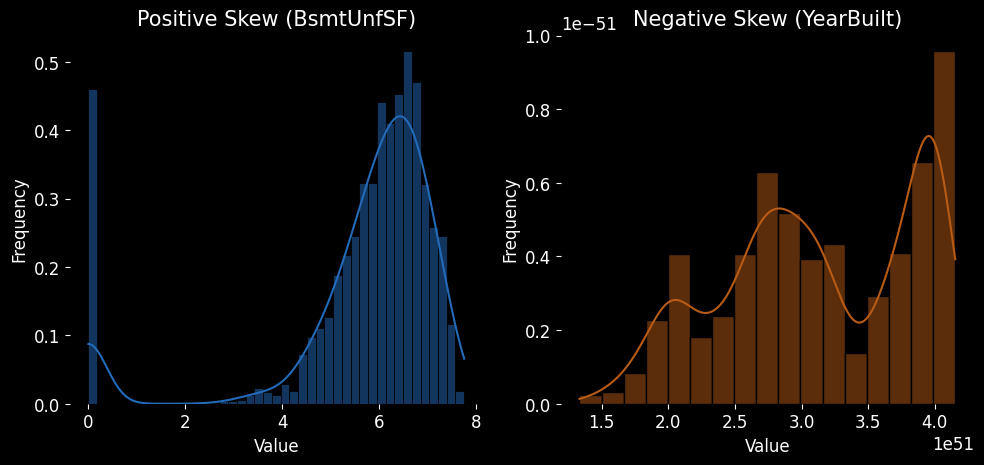

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 설정: 폰트 및 테마 스타일
mpl.rcParams['font.family'] = 'DejaVu Sans'  # 대체 가능 폰트
mpl.rcParams['font.size'] = 12

# 도화지 준비
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes

# 다크 배경 설정
fig.patch.set_facecolor('black')
ax1.set_facecolor('black')
ax2.set_facecolor('black')

# 히스토그램 그리기 (Seaborn)
sns.histplot(data=df, x='BsmtUnfSF', kde=True, stat='density', color='#236AB9', ax=ax1)
sns.histplot(data=df, x='YearBuilt', kde=True, stat='density', color='#B85B14', ax=ax2)

# 축/라벨 색상 및 설정 통일
for ax, title in zip([ax1, ax2], ['Positive Skew (BsmtUnfSF)', 'Negative Skew (YearBuilt)']):
    ax.set_xlabel('Value', color='white')
    ax.set_ylabel('Frequency', color='white')
    ax.set_title(title, fontsize=15, color='white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    # 축 테두리 제거
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


## Transforming target

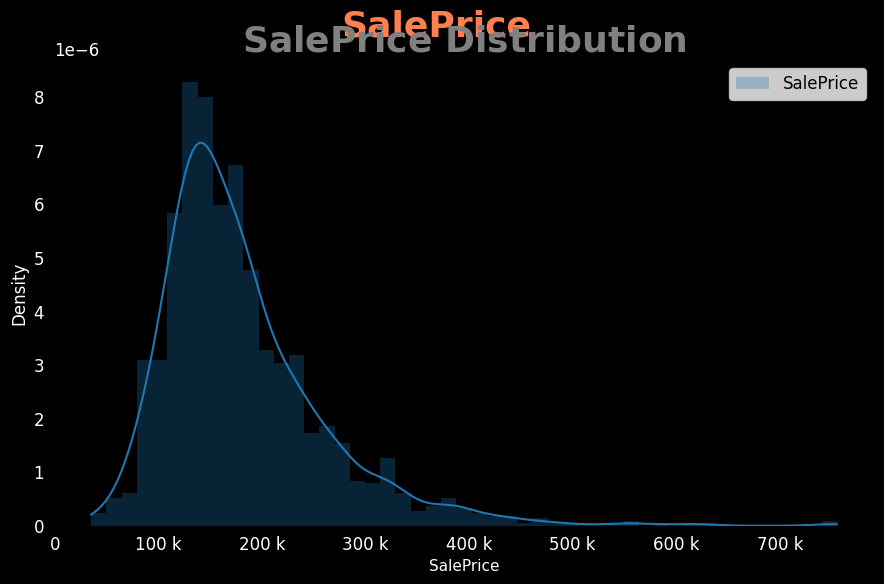

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

plt.figure(figsize=(9, 6))
ax = sns.histplot(y, stat='density', linewidth=0, color='#ff7f50', kde=True, alpha=0.3)

# 다크 배경
ax.set_facecolor('black')
ax.figure.set_facecolor('black')

# 축 스타일
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', colors='white', bottom=False)
ax.tick_params(axis='y', colors='white', left=False)

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# 단위 포맷
ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.xlabel('SalePrice', fontsize=11, color='white')
plt.ylabel('Density', color='white')

# 🟧 원본처럼 SalePrice Distribution 텍스트 한 줄로
plt.title("SalePrice Distribution", fontsize=26, loc='center', weight='bold')
# 강조 색상 적용
title = ax.title
title_text = title.get_text().replace("SalePrice", r"$\bf{SalePrice}$")
title.set_text(title_text)
title.set_color("grey")  # 기본 전체 색
title.set_fontsize(26)

# 강조 부분 색 변경
ax.annotate("SalePrice", xy=(0.35, 1.05), xycoords='axes fraction',
            fontsize=26, color='#ff7f50', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# 왜도 처리 (로그 변환)
y['SalePrice']=np.log1p(y["SalePrice"])

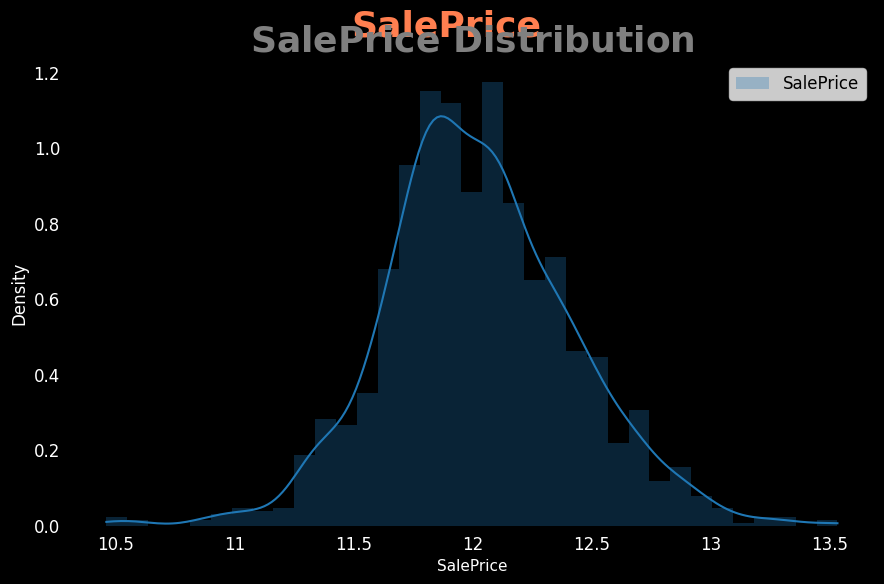

In [ ]:
#왜도 처리 후의 SalePrice
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

plt.figure(figsize=(9, 6))
ax = sns.histplot(y, stat='density', linewidth=0, color='#ff7f50', kde=True, alpha=0.3)

# 다크 배경
ax.set_facecolor('black')
ax.figure.set_facecolor('black')

# 축 스타일
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', colors='white', bottom=False)
ax.tick_params(axis='y', colors='white', left=False)

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# 단위 포맷
ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.xlabel('SalePrice', fontsize=11, color='white')
plt.ylabel('Density', color='white')

# 🟧 원본처럼 SalePrice Distribution 텍스트 한 줄로
plt.title("SalePrice Distribution", fontsize=26, loc='center', weight='bold')
# 강조 색상 적용
title = ax.title
title_text = title.get_text().replace("SalePrice", r"$\bf{SalePrice}$")
title.set_text(title_text)
title.set_color("grey")  # 기본 전체 색
title.set_fontsize(26)

# 강조 부분 색 변경
ax.annotate("SalePrice", xy=(0.35, 1.05), xycoords='axes fraction',
            fontsize=26, color='#ff7f50', fontweight='bold')

plt.tight_layout()
plt.show()


## Encoding Categorical Features

In [ ]:
cat_cols = df.dtypes[df.dtypes == object]
cat_cols = cat_cols.index.tolist()

#원핫인코딩
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [ ]:
X = df_enc[df_enc['train']==1]
test=df_enc[df_enc['train']==0]
X.drop(['train'], axis=1, inplace=True)     #기준의 train과 test셋으로 나누는 과
test.drop(['train'], axis=1, inplace=True)

<ipython-input-89-151b02b8f6f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['train'], axis=1, inplace=True)
<ipython-input-89-151b02b8f6f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['train'], axis=1, inplace=True)


# 모델링

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=12345)

In [ ]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

**RMSE란?**

: 평균 제곱근 오차

(예측값 - 실제값)의 제곱 평균의 제곱근..

작을수록 좋음.

큰 오차에 민감하게 반응한다.(오차를 제곱하기 때문에!)

## Lasso Regression + Cross-Validation

비용함수를 최소화하는 선형 모델

이 비용함수에는 패널티가 포함되어있는데, L1 패널티라고 불리며, alpha값이 이 패널티의 강도를 조절한다.

(즉, Lasso = 선형회귀모델 + L1)

이 패널티는 일부 변수의 계수를 0으로 감소시키는 역할

➡️ 모델이 더 간결해지고 해석하기 쉬워짐


✔️ alpha값이 클수록 더 많은 계수가 0이 되도록 함

✔️ 무의미한 변수들은 0으로 만들어 과적합을 줄여주고, 유의미한 특징만 남기는 특징 선택 기능도 함께 수행

In [ ]:
lasso = Lasso(max_iter = 100000)

# 최적의 alpha값 찾기
lassocv = LassoCV(alphas=None, cv=10, max_iter = 100000)    # 여러개의 alpha값을 시도해보고, 가장 좋은 성능을 내는 alpha를 찾는 과정
lassocv.fit(X_train, y_train)

#모델 학습
lasso.set_params(alpha=lassocv.alpha_)  #lassocv.alpha_ : 최적의 alpha값 // "Lasso야 lassocv가 골라준 최고의 alpha값으로 학습해라!"
lasso.fit(X_train, y_train)

print('The Lasso I:')
print('Alpha =', lassocv.alpha_)
print('RMSE =', rmse(y_test, lasso.predict(X_test)))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Lasso I:
Alpha = 5.722604371681073e+47
RMSE = 0.3085600149859336


In [ ]:
alpha = np.geomspace(1e-5, 1e0, num=6)
lasso_cv_model = LassoCV(alphas = alpha, cv = 10, max_iter = 100000).fit(X_train,y_train)
lasso_tuned = Lasso(max_iter = 100000).set_params(alpha = lasso_cv_model.alpha_).fit(X_train,y_train)
print('The Lasso II:')
print("Alpha =", lasso_cv_model.alpha_)
print("RMSE =", rmse(y_test, lasso_tuned.predict(X_test)))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Lasso II:
Alpha = 0.001
RMSE = 0.12325755143705641


The Lasso I : sklearn이 알아서 alpha 후보값 수십개를 생성

- 내부 작동을 볼 수 없음

The Lasso 2: 내가 alpha후보값 6개 정한 것 중에서 최고의 alpha값 선정

- 정확히 어떤 값을 테스트 했는지, alpha별 성능 변화 시각화 가능

## Ridge Regressoin + Cross-Validation

선형회귀 모델 + L2 패널티

- alpha값이 작을수록, 더 선형적인 형태를 띈다(단순화됨)
- ridge회귀는 계수를 축소시켜 복잡도와, 다중 공선성 문제를 줄이는데 도움을 줌

In [ ]:
print(X_train.isnull().sum().sum())
print(y_train.isnull().sum())

0
SalePrice    0
dtype: int64


In [ ]:
print(np.isinf(X_train).sum().sum())
print(np.isinf(y_train).sum())

0
SalePrice    0
dtype: int64


In [ ]:
print(X_train.max().max())
# 얘 값이 너무 커서 오류가 나는 듯

4.153288531579904e+51


In [ ]:
X_train.max().sort_values(ascending=False).head(10)

,0
YearBuilt,4153288531579904078009415829371635937628432526...
YearRemodAdd,2010
GarageArea,1220.0
Total_House_SF,50.014822
Total_Home_Quality,41.84953
LotFrontage,34.350886
LotArea,12.279537
OverallQual,10
GrLivArea,9.550032
1stFlrSF,8.079928


In [ ]:
X_train.loc[X_train['YearBuilt'] > 2010, 'YearBuilt'] = 2010
X_test.loc[X_test['YearBuilt'] > 2010, 'YearBuilt'] = 2010

In [ ]:
X_train.max().sort_values(ascending=False).head(10)

,0
YearRemodAdd,2010
YearBuilt,2010.0
GarageArea,1220.0
Total_House_SF,50.014822
Total_Home_Quality,41.84953
LotFrontage,34.350886
LotArea,12.279537
OverallQual,10
GrLivArea,9.550032
1stFlrSF,8.079928


In [ ]:
alphas = np.geomspace(1e-9, 5, num=100)

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(X_train, y_train)

ridge = Ridge(alpha=ridgecv.alpha_)
ridge.fit(X_train, y_train)

print('Ridge Regression:')
print('Alpha =', ridgecv.alpha_)
print('RMSE =', rmse(y_test, ridge.predict(X_test)))


Ridge Regression:
Alpha = 5.0
RMSE = 0.12232298277149004


## Support Vector Regression (SVR) + Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVR

kf=KFold(shuffle=True, random_state=1234, n_splits=10)

X_train_scale=RobustScaler().fit_transform(X_train)
X_test_scale=RobustScaler().fit_transform(X_test)

parameters={'C':[20,30,40], 'gamma': [1e-4, 3e-4, 5e-4],'epsilon':[0.1, 0.01, 0.05]}
svr=SVR(kernel='rbf')
clf=GridSearchCV(svr, parameters, cv=kf)
clf.fit(X_train_scale, y_train)
clf.best_params_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

{'C': 30, 'epsilon': 0.01, 'gamma': 0.0003}

___
✅SVR이란?(Support Vector Regression)

주어진 데이터에 대해 오차가 n이하인 에측을 최대하 많이 만드려고 노력하는 회귀 알고리즘

- C: 허용할 오차 범위
    - 작을수록 일반화 (언더피팅 가능)
    - 클수록 오차를 많이 허용하지 않아 복잡한 그래프가 그려짐 (과적합 가능성)

- 커널: 비선형 문제를 해결하기 위해 고차원으로 매핑
    - 보통 linear, rbf, poly 사용

- gamma: rbf커널에서 작동범위를 조절하는 파라미터
    - 작을수록 부드러운 곡선이 만들어짐

- epsilon: 오차를 허용하는 범위
    - 예측이 e안에 있으면 벌점 없음


🌱 즉, SVR은 e범위내의 오차는 괜찮고, 넘어가면 벌점이라는 컨셉의 회귀 알고리즘으로,

C, epsilon, gamma 3가지 파라미터를 조절해서 복잡도 혹은 정확도를 제어함

---
**코드설명**

SVR모델에 대해서 하이퍼파라미터 튜닝 + 교차검증을 통해 최적 성능을 찾는 코드

사용 모델 : SVR(kernel='rbf') → 비선형 회귀

정규화: RobustScaler() → 이상치에 강한 정규화

튜닝 방법: GridSearchCV() → 격자 탐색 기반의 하이퍼파라미터 최적화

평가방법: KFold(cv=10) → 10 폴드 교차검증

최종 출력: clf.best_params → 최적 파라미터 확인




In [ ]:
svr=SVR(kernel='rbf', C=30, epsilon = 0.01, gamma = 0.0003)
svr.fit(X_train_scale, y_train)

print('SVR Regression')
print('RMSE =' , rmse(y_test, svr.predict(X_test_scale)))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR Regression
RMSE = 0.1269616332961692


# 해석

In [ ]:
print('Out of {} coefficients, {} are non-zero with Lasso.'.format(len(lasso_tuned.coef_), len(lasso_tuned.coef_.nonzero()[0])))

Out of 288 coefficients, 79 are non-zero with Lasso.


<ipython-input-122-ebcc3bffa088>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


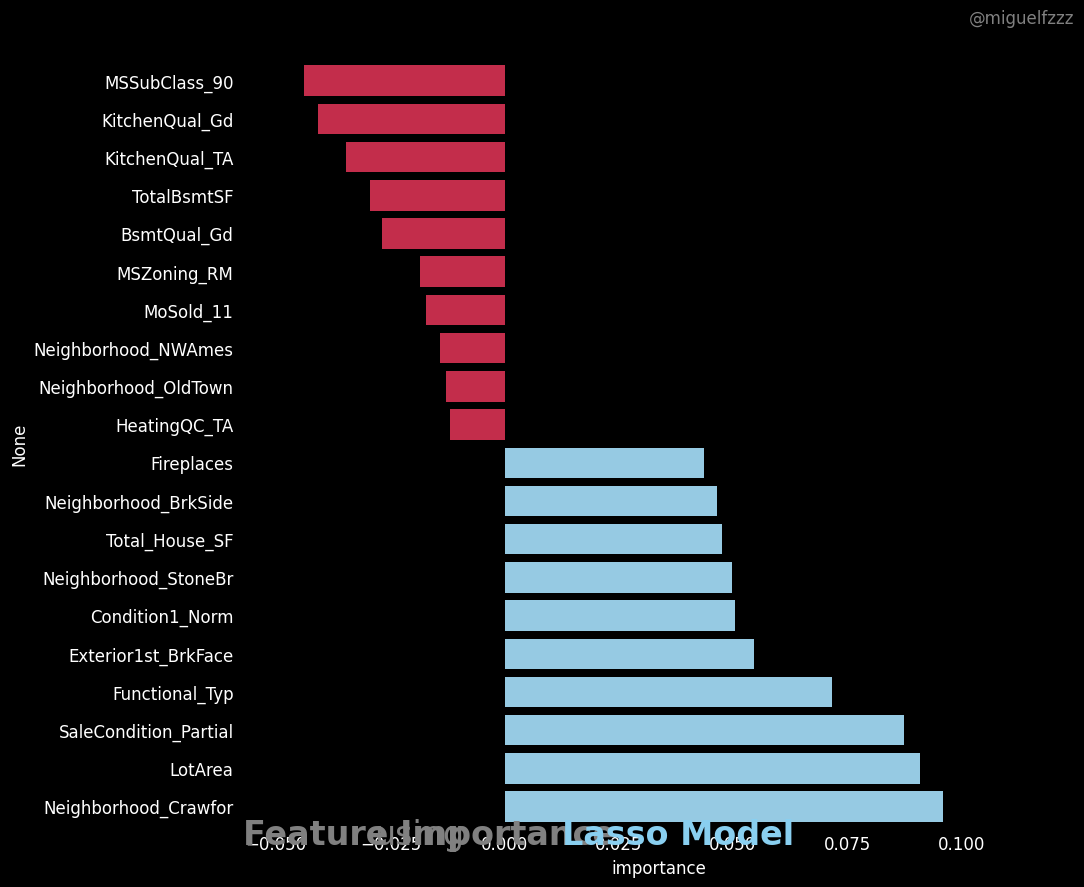

In [ ]:
# feature importances

coefs=pd.Series(lasso_tuned.coef_, index=test.columns)
lasso_coefs = pd.concat([coefs.sort_values().head(10),
                        coefs. sort_values().tail(10)])

lasso_coefs = pd.DataFrame(lasso_coefs, columns=['importance'])

# 시각화 시작
# 시각적 폭 차이 조정 + 텍스트 위치 수정 버전

plt.figure(figsize=(11, 9))
ax = sns.barplot(
    y=lasso_coefs.index,
    x=lasso_coefs['importance'],
    palette=['crimson' if val < 0 else '#89CFF0' for val in lasso_coefs['importance']]
)

# 배경 설정
ax.set_facecolor('black')
ax.figure.set_facecolor('black')

# 축과 테두리 제거
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', colors='white', bottom=False)
ax.tick_params(axis='y', colors='white', left=False)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# x축의 시각 폭 강조 (좌우로 조금 더 padding)
x_min = lasso_coefs['importance'].min() * 1.3
x_max = lasso_coefs['importance'].max() * 1.3
ax.set_xlim(x_min, x_max)

# 텍스트 위치 조정
y_top = len(lasso_coefs) - 0.5
plt.text(x_min, y_top + 0.5, "Feature Importance", size=24, color="grey", fontweight="bold")
plt.text(x_min * 0.5, y_top + 0.5, "using", size=24, color="grey")
plt.text(x_max * 0.1, y_top + 0.5, "Lasso Model", size=24, color="#89CFF0", fontweight="bold")

# Author
plt.text(x_max, -1.5, "@miguelfzzz", fontsize=12, ha="right", color='grey')

plt.tight_layout()
plt.show()


파란색으로 표시된 모든 특징들은 주택 판매 가격에 긍정적인 영향
즉, 이러한 특징이 있을수록 집값이 올라간다는 의미

반대로, 빨간색으로 표시된 모든 특징들은 주택 판매 가격에 부정적인 영향
즉, 이러한 특징이 강할수록 집값이 낮아질 수 있다는 의미